In [1]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import re
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
df_train = pd.read_excel('/content/gdrive/My Drive/TA/Data-train_sentimen_covid.xlsx')
df_dev = pd.read_excel('/content/gdrive/My Drive/TA/Data-dev_sentimen_covid.xlsx')
df_test = pd.read_excel('/content/gdrive/My Drive/TA/Data-test_sentimen_covid.xlsx')
df_dataset = pd.concat([df_train, df_dev, df_test])
pd.set_option('display.max_colwidth', -1)
df_dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


,Unnamed: 0,Sentiment,Tweet
0,5158,pos,Akhirnya sekolah dapet undangan vaksin! Yay!
1,2187,net,"@kei_arie ga perlu ragu bro, vaksin astra zeneca itu aman dan halal, MUI udah keluarkan fatwanya kok, apalagi vaksiâ€¦ https://t.co/y5Lq77FfQH"
2,5244,net,Aku sedang sibuk memantau sukarelawan belia bertugas di Pusat Vaksin Kuala Terengganu. Sekarang tengah vaksin Fasaâ€¦ https://t.co/J9aagUcnlf
3,7910,net,Kalian tau gak kalau Kemenparekraf Dukung Prioritas Vaksin Untuk Pelaku Sektor Ekonomi Kreatifâ€¦ https://t.co/iwSolGzVrx
4,3640,net,@SantorinisSun Sudah jelas 'KASUS' Vaksin ini tdk Objektif lg. Nuansa 'REVENGE' terhdp KARAKTER seseorang.Kalau iniâ€¦ https://t.co/lXTo5fbto4
...,...,...,...
395,49,neg,Kalok @jokowi nalarnya normal ini protes terkeras lg teradikal: woy @jokowi bini gue dah suntik vaksin 2x tapi masiâ€¦ https://t.co/pxF5gSFror
396,785,net,"makin ngeri yaa covid ini, siapa aja bisa kena skrg bahkan yg udh di vaksin pun :(padahal punya project habis lebaâ€¦ https://t.co/ShfAqRS1kw"
397,118,net,kedatangan vaksin covid 19 tahap 8 Dukung Jokowi Lawan Pandemihttps://t.co/qeQ9ace6NO
398,694,net,Life does works in a mysterious way hari ini tiba2 dimintain tolong nganter sepupu vaksin ke dokter anak turns outâ€¦ https://t.co/mModvId9m7


In [4]:
#df_dataset.to_excel('df_dataset.xlsx', index=False)
#files.download('df_dataset.xlsx')

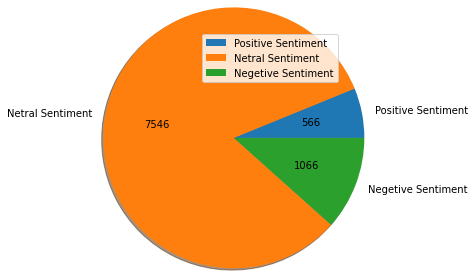

In [5]:
sentiments = ['Positive Sentiment', 'Netral Sentiment', 'Negetive Sentiment'] 
total = [(df_dataset['Sentiment'] =='pos').sum(), (df_dataset['Sentiment'] == 'net').sum(), (df_dataset['Sentiment'] == 'neg').sum()] 
plt.pie(total, labels=sentiments, shadow=True, radius=1.5, autopct = lambda p:f'{p*sum(total)/100 :.0f}')
plt.legend()
plt.show()

In [6]:
#df_dataset['Sentiment'].value_counts()

In [7]:
def Sentiment(x):
    if(x == 'neg'):
        return '-1'
    if(x == 'net'):
        return '0'
    if(x == 'pos'):
        return '1'
df_train['Sentiment'] =df_train['Sentiment'].apply(Sentiment)
df_dev['Sentiment'] =df_dev['Sentiment'].apply(Sentiment)
df_test['Sentiment'] =df_test['Sentiment'].apply(Sentiment)

## Data Preparation

In [8]:
df_train['Sentiment'].value_counts(normalize=True)

0     0.833000
-1    0.109125
1     0.057875
Name: Sentiment, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


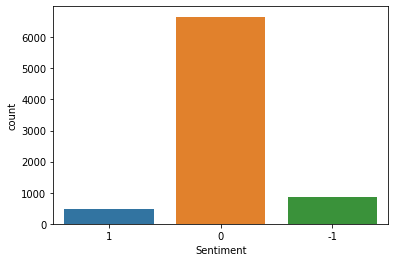

In [9]:
sns.countplot(df_train['Sentiment'])

In [10]:
pos = df_train[df_train.Sentiment == '1']
net = df_train[df_train.Sentiment == '0'][:1000]
neg = df_train[df_train.Sentiment == '-1']
df_train_balanced = pd.concat([pos,net,neg])
df_train_balanced['Sentiment'].value_counts()

0     1000
-1    873 
1     463 
Name: Sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


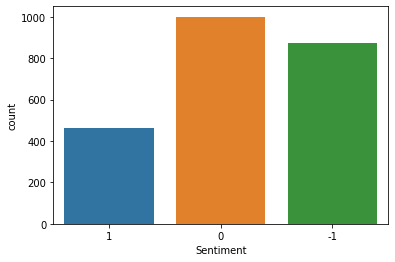

In [11]:
sns.countplot(df_train_balanced['Sentiment'])

In [12]:
df_dev['Sentiment'].value_counts()

0     648
-1    85 
1     45 
Name: Sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


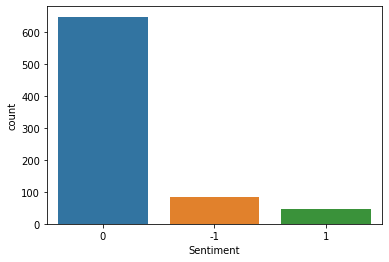

In [13]:
sns.countplot(df_dev['Sentiment'])

In [14]:
pos = df_dev[df_dev.Sentiment == '1']
net = df_dev[df_dev.Sentiment == '0'][:134]
neg = df_dev[df_dev.Sentiment == '-1']
df_dev_balanced = pd.concat([pos,net,neg])
df_dev_balanced['Sentiment'].value_counts(normalize=True)

0     0.507576
-1    0.321970
1     0.170455
Name: Sentiment, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


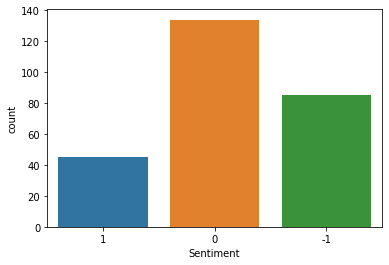

In [15]:
sns.countplot(df_dev_balanced['Sentiment'])

In [16]:
df_test['Sentiment'].value_counts()

0     234
-1    108
1     58 
Name: Sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


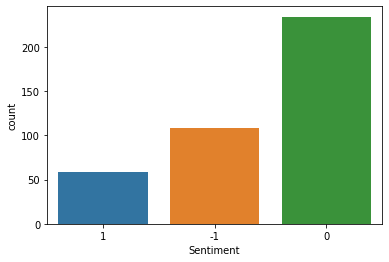

In [17]:
sns.countplot(df_test['Sentiment'])

## Feature Selection ( Cleaning + Case Folding + Remove Punc + Remove Single Char)

In [18]:
def cleaning(Tweet):
    #remove hyper link
    Tweet = re.sub(r'http\S+', '', Tweet)
    #remove @mention
    Tweet = re.sub('@[^\s]+', '', Tweet)
    #remove Hashtaq
    Tweet = re.sub(r'#([^\s]+)', '', Tweet)
    #remove multiple whitespace into single whitespace
    Tweet = re.sub('\s+',' ',Tweet)
    #remove whitespace leading & trailing
    Tweet = Tweet.strip()
    #remove Number
    Tweet = re.sub(r'\d+', '', Tweet)
    # Remove non ASCII chars
    Tweet = re.sub(r'[^\x00-\x7f]', r'', Tweet)
    Tweet = re.sub(r'(\\u[0-9A-Fa-f]+)', r'', Tweet)
    Tweet = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", Tweet)
    Tweet = re.sub(r'\\u\w\w\w\w', '', Tweet)
    #remove double term
    #Tweet = re.sub(r'\b\w[1,2]\b', '',Tweet)
    return Tweet
  
df_train["Tweet"] = df_train["Tweet"].apply(cleaning)
df_train_balanced["Tweet"] = df_train_balanced["Tweet"].apply(cleaning)

In [19]:
df_train_balanced

,Unnamed: 0,Sentiment,Tweet
0,5158,1,Akhirnya sekolah dapet undangan vaksin! Yay!
27,5303,1,"Alhamdulillah lansia diedukasi pada paham amp; ngerti, mereka paham kalo kena yah insyallah jd bapil biasa bagi org yg"
30,3892,1,"Setuju Pak. Sehat bukan soal vaksin. Sehat itu tentang KESELARASAN RAGA, JIWA, AKAL, DAN PASTINYA BUD"
80,7522,1,"Ingat pesan wapres bahwa kita selalu harus patuh prokes, jangan pernah lelah. Bagi yg sudah dapat"
81,5989,1,"Bismillah - Alhamdulillah Sehat, Vaksin Ke-.... Gedung Pemprov Jatim"
...,...,...,...
7944,5012,-1,Abis vaksin terbitlah tunduh dan lapar
7956,2413,-1,gw lbh percaya tydk pakai vaksin
7964,2681,-1,"Elo aja kale, klo emang vaksin baik dan elo doyan ywd jatah gue buat elo aja...selang air............... !!"
7973,1039,-1,"Gak di vaksin positif, di vaksin positif. Terus ngapain di vaksin Gw sih ogah.."


In [20]:
def preprocessing(Tweet):
    #Tweet = re.sub(r'(.)\1+',r'\1', Tweet)
    Tweet = Tweet.lower()
    #Tweet = Tweet.translate(str.maketrans("","",string.punctuation))
    return Tweet
    
df_train["Tweet"] = df_train["Tweet"].apply(preprocessing)
df_train_balanced["Tweet"] = df_train_balanced["Tweet"].apply(preprocessing)

In [21]:
df_train_balanced

,Unnamed: 0,Sentiment,Tweet
0,5158,1,akhirnya sekolah dapet undangan vaksin! yay!
27,5303,1,"alhamdulillah lansia diedukasi pada paham amp; ngerti, mereka paham kalo kena yah insyallah jd bapil biasa bagi org yg"
30,3892,1,"setuju pak. sehat bukan soal vaksin. sehat itu tentang keselarasan raga, jiwa, akal, dan pastinya bud"
80,7522,1,"ingat pesan wapres bahwa kita selalu harus patuh prokes, jangan pernah lelah. bagi yg sudah dapat"
81,5989,1,"bismillah - alhamdulillah sehat, vaksin ke-.... gedung pemprov jatim"
...,...,...,...
7944,5012,-1,abis vaksin terbitlah tunduh dan lapar
7956,2413,-1,gw lbh percaya tydk pakai vaksin
7964,2681,-1,"elo aja kale, klo emang vaksin baik dan elo doyan ywd jatah gue buat elo aja...selang air............... !!"
7973,1039,-1,"gak di vaksin positif, di vaksin positif. terus ngapain di vaksin gw sih ogah.."


In [22]:
x_train_balanced = df_train_balanced["Tweet"]
x_train = df_train["Tweet"]

y_train_balanced = df_train_balanced["Sentiment"]
y_train= df_train["Sentiment"]

x_dev_balanced = df_dev_balanced['Tweet']
x_dev = df_dev["Tweet"]

y_dev_balanced = df_dev_balanced['Sentiment']
y_dev = df_dev["Sentiment"]

x_test = df_test['Tweet']
y_test = df_test['Sentiment']

## TF-IDF

In [23]:
vect = TfidfVectorizer().fit(x_train_balanced)

x_train_vect_balanced = vect.transform(x_train_balanced)
x_train_vect = vect.transform(x_train)

x_dev_vect_balanced = vect.transform(x_dev_balanced)
x_dev_vect = vect.transform(x_dev)

x_test_vect = vect.transform(x_test)

In [24]:
x_train_vect_balanced.shape

(2336, 6304)

In [25]:
y_train.shape

(8000,)

## Train Model + Best Parameters

In [26]:
#kernel = ['poly','sigmoid','rbf']
#for i in kernel:
#  model = SVC(kernel=i, C=0.1, gamma=0.01)
#  model.fit(x_train_vect_balanced, y_train_balanced)
#  print('for kernel', i)
#  print('akurasi testing', model.score(x_dev_vect_balanced, y_dev_balanced))

In [27]:
parameters = { 
    'kernel': ['poly','sigmoid','rbf'], 
    'C': [0.1, 1, 10], 
    'gamma' : [1, 0.1, 0.001]
    }

clf = GridSearchCV(SVC(random_state=42), param_grid=parameters, verbose=1, scoring='accuracy')

clf.fit(x_train_vect, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.001],
                         'kernel': ['poly', 'sigmoid', 'rbf']},
             scoring='accuracy', verbose=1)

In [28]:
clf.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [29]:
best_model = SVC (kernel='rbf', C=10, gamma=1)
best_model.fit(x_train_vect, y_train)
print('acc training', best_model.score(x_train_vect, y_train))

acc training 0.99975


## Validasi Model

In [30]:
predict_val = best_model.predict(x_dev_vect)
accuracy = accuracy_score(y_dev, predict_val)
accuracy

0.8354755784061697

In [31]:
predict_val.shape

(778,)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


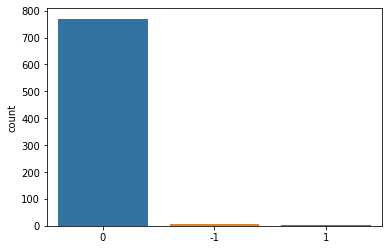

In [32]:
sns.countplot(predict_val)

## Testing Model

In [33]:
predict_test = best_model.predict(x_test_vect)
accuracy = accuracy_score(y_test, predict_test)
accuracy

0.6075

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


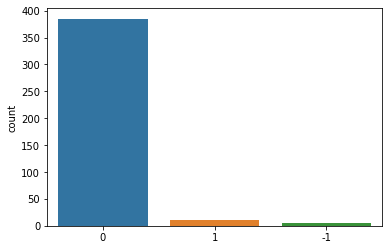

In [35]:
sns.countplot(predict_test)

In [ ]:
#df_pred = pd.DataFrame(predict)
#df_pred.value_counts()

In [ ]:
#df_test

In [ ]:
#tweet = np.array(df_test['Tweet'])
#pred = pd.DataFrame(tweet, df_pred)
#pred
#pred = pd.DataFrame(df_test['Tweet'], df_pred)
#pred

In [ ]:
#df_test['Sentiment'].value_counts()

In [ ]:
#len(df_test)

## Confusion Matrix

In [36]:
print(classification_report(y_test, predict_test))

              precision    recall  f1-score   support

          -1       1.00      0.05      0.09       108
           0       0.60      0.99      0.75       234
           1       0.70      0.12      0.21        58

    accuracy                           0.61       400
   macro avg       0.77      0.38      0.35       400
weighted avg       0.72      0.61      0.49       400



In [37]:
print('F1-Score pada pengujian adalah')
print(f1_score(y_test, predict_test, average='macro'))

F1-Score pada pengujian adalah
0.34691434439016433


In [38]:
print('Recall pada pengujian adalah')
print(recall_score(y_test, predict_test, average='macro'))

Recall pada pengujian adalah
0.3847218128827324


In [39]:
print('Precision pada pengujian adalah')
print(precision_score(y_test, predict_test, average='macro'))

Precision pada pengujian adalah
0.7666666666666666


In [41]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, predict_test, average="macro")

(0.7666666666666666, 0.3847218128827324, 0.34691434439016433, None)

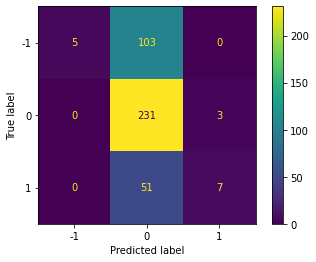

In [42]:
cm = confusion_matrix(y_test, predict_test)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
display.plot()
plt.show()

# Predict Sentimen

In [ ]:
text = "$&pada kemana ni kalian? mau divaksin kah? vaksin bagus buat mengurangi covid"
text_pred = [text]
text_pred = pd.DataFrame(text_pred, columns=['Tweet'])
text_pred["Tweet"] = text_pred["Tweet"].apply(cleaning)
test = text_pred["Tweet"]
vect_test = vect.transform(test)
best_model.predict(vect_test)

In [ ]:
print(f1_score(y_test, predict, average=None))

In [ ]:
f1_score = ((0.402+0.768+0.405)/3)*100
f1_score